# New York City Taxis Tips

On s'intéresse ici à la prédiction du montant de pourboires (tips) payé pour des courses de taxi à New-York. On dispose d'un jeu de données d'entraînement représentant 100 000 courses de taxis effectuées en janvier 2024 pour lesquelles le montant des pourboires est connu.

In [23]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab 
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# I. Les données

Les données d'entraînement et de test sont stockées dans le dossier ./data/ dans les fichiers train.csv et test.csv. Ces données sont ensuite chargées dans les DataFrames train_df et test_df.

In [4]:
import os

_REP_PATH_ = os.getcwd()

In [9]:
# Initialisation des DataFrames contenant les données

# DataFrame des données d'entrainement
train_df = pd.read_csv(_REP_PATH_+'/data/train.csv', index_col = 0)

# DataFrame des données de test
test_df = pd.read_csv(_REP_PATH_+'/data/test.csv', index_col = 0)


# Affichage des premiers individus des DataFrames
train_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon
0,1,2024-01-15 20:37:28,2024-01-15 20:56:43,1.0,3.30,1.0,N,1,19.1,3.5,0.5,4.80,0.0,1.0,2.5,0.0,40.734576,-74.002875,40.768615,-73.965635
1,2,2024-01-25 19:41:24,2024-01-25 19:44:42,1.0,0.72,1.0,N,1,5.8,2.5,0.5,2.46,0.0,1.0,2.5,0.0,40.768615,-73.965635,40.780436,-73.957012
2,2,2024-01-25 15:48:48,2024-01-25 16:24:23,2.0,7.45,1.0,N,1,38.7,0.0,0.5,3.00,0.0,1.0,2.5,0.0,40.717773,-74.007880,40.780436,-73.957012
3,2,2024-01-27 00:47:26,2024-01-27 00:55:55,1.0,1.53,1.0,N,1,10.0,1.0,0.5,2.25,0.0,1.0,2.5,0.0,40.720889,-73.996919,40.747746,-73.978492
4,2,2024-01-28 13:14:26,2024-01-28 13:22:34,1.0,1.53,1.0,N,1,10.0,0.0,0.5,3.50,0.0,1.0,2.5,0.0,40.768615,-73.965635,40.747746,-73.978492


## Données d'entraînement vs données test

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627163 entries, 0 to 2627162
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   payment_type           int64         
 8   fare_amount            float64       
 9   extra                  float64       
 10  mta_tax                float64       
 11  tolls_amount           float64       
 12  improvement_surcharge  float64       
 13  congestion_surcharge   float64       
 14  Airport_fee            float64       
 15  PU_location_lat        float64       
 16  PU_location_lon        float64       
 17  DO_location_lat        float64       
 18  DO_location_lon       

In [13]:
train_df.describe() - test_df.describe()

,Airport_fee,DO_location_lat,DO_location_lon,PU_location_lat,PU_location_lon,RatecodeID,VendorID,congestion_surcharge,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,payment_type,tip_amount,tolls_amount,trip_distance
count,-2.527163e+06,-2.527163e+06,-2.527163e+06,-2.527163e+06,-2.527163e+06,-2.527163e+06,-2.527163e+06,-2.527163e+06,-2.527163e+06,-2.527163e+06,-2.527163e+06,-2.527163e+06,-2.527163e+06,-2.527163e+06,NaN,-2.527163e+06,-2.527163e+06
mean,-1.683047e-03,6.649990e-07,1.322962e-05,7.895556e-05,-1.425363e-04,-2.287472e-02,2.163494e-04,2.124726e-03,-1.234212e-02,-4.554352e-02,-2.573317e-05,-1.529911e-04,-4.003920e-03,1.208485e-03,NaN,1.882941e-03,-1.144276e-02
std,-2.583026e-03,-6.199025e-05,9.511550e-05,3.874467e-05,-1.847739e-04,-1.158735e-01,-1.292599e-04,-3.697207e-03,-1.151490e-02,-1.049573e-01,1.110404e-03,7.520157e-04,-3.131846e-03,2.146457e-03,NaN,2.925993e-03,-1.194245e-02
min,0.000000e+00,3.194477e-03,4.585618e-02,1.782656e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00
max,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.562997e-02,0.000000e+00,0.000000e+00,0.000000e+00,-2.500000e+00,-6.052000e+02,0.000000e+00,-3.500000e+00,-2.000000e+00,0.000000e+00,NaN,-4.620000e+01,-2.636000e+01


On note que les données d'entraînement et de test concernent le même mois. 

Les écart-types et moyennes sont proche pour les jeux de données, avec un écart inférieur à 0.1 pour chacune des variables.

## Correlation

In [20]:
correlation_matrix = train_df.drop(columns= ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'store_and_fwd_flag']).corr()

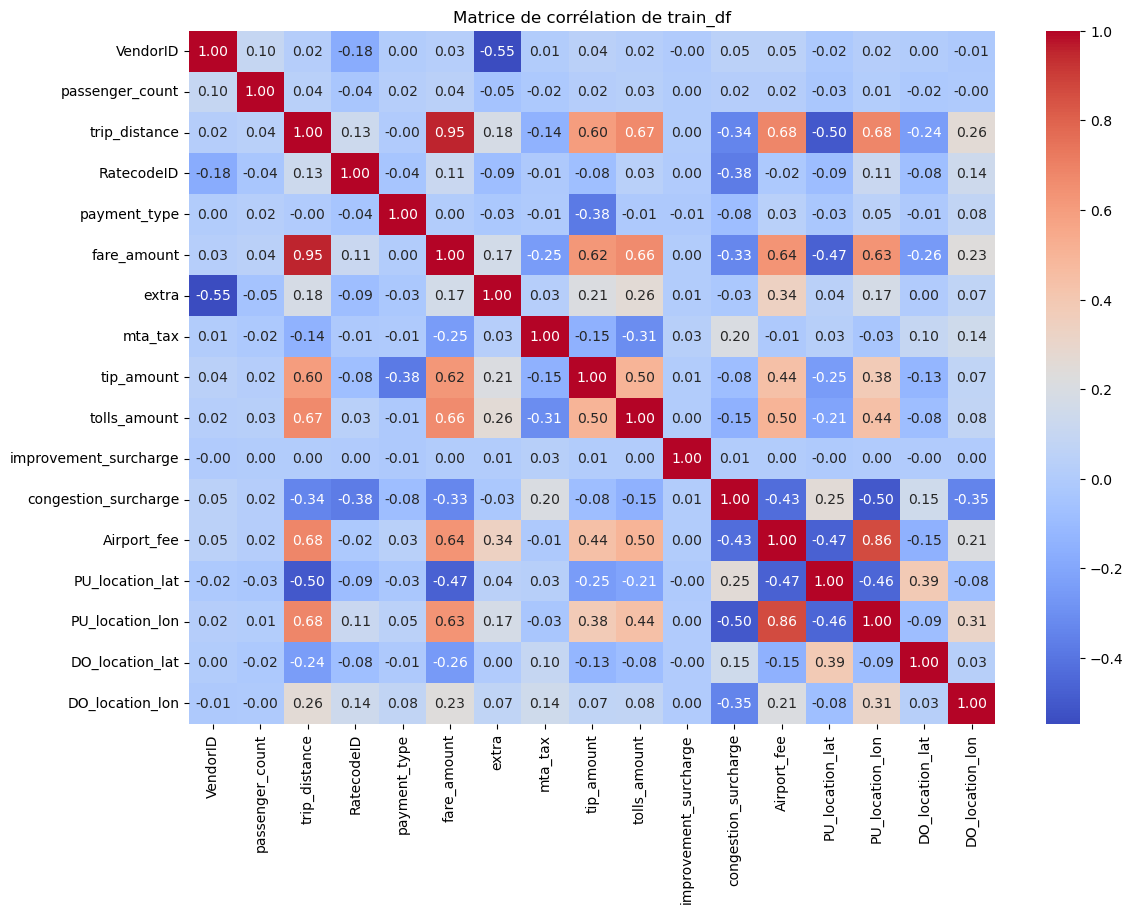

In [22]:


# Création de la heatmap
matplotlib.pylab.figure(figsize=(13,9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# Afficher le graphique
plt.title("Matrice de corrélation de train_df")
plt.show()

On observe une forte corrélation entre les variables `trip_distance` et `fare_amount`. Cela était prévisible puisque les trajets plus longs coûtent plus cher. Nous allons tout de même conserver ces deux variables dans la suite. Les variables `PU_location_lon` et `Airport_fee` sont aussi fortement corrélées, ce qui confirme que la taxe d'aéroport concerne la localisation du départ de la course.

## Étude des données en ACP

In [24]:
scaler = StandardScaler()
X_ACP = train_df.drop(columns= ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'store_and_fwd_flag'])
X_ACP_standardized = scaler.fit_transform(X_ACP)

In [25]:
mypca = PCA(n_components= 5)

mypca.fit(X_ACP_standardized)

# Pourcentage de la variance expliquée par chacune des composantes sélectionnées.
print(mypca.singular_values_) # Valeurs de variance
print(mypca.explained_variance_ratio_) #  Pourcentages

# Résultats de l'ACP
data_sortie= mypca.fit_transform(X_ACP_standardized)

# Bruit estimé lié à la covariance
print(mypca.noise_variance_)

[697.7409729  406.24740688 399.72232436 356.8943033  338.55321207]
[0.28637792 0.09708056 0.09398702 0.07492561 0.06742252]
0.5386310708344757


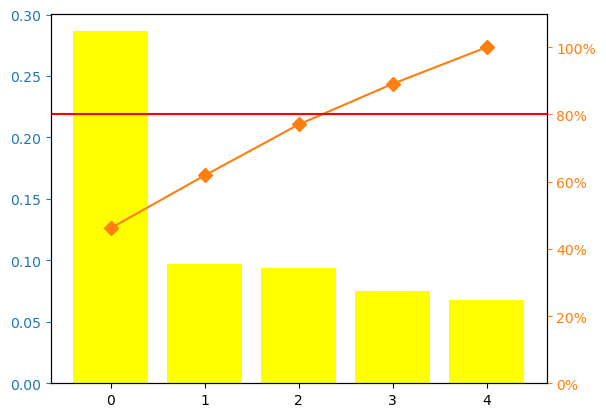

In [26]:
from matplotlib.ticker import PercentFormatter

def pareto(data) :

    y = list(data)
    x = range(len(data))
    
    ycum = np.cumsum(y)/sum(y)*100

    fig, ax = plt.subplots()
    ax.bar(x,y,color="yellow")
    ax2 = ax.twinx()
    ax2.plot(x,ycum, color="C1", marker="D", ms=7)
    ax2.axhline(y=80,color="r")
    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax.tick_params(axis="y", colors="C0")
    ax2.tick_params(axis="y", colors="C1")

    plt.ylim(0,110)
    plt.show()

pareto(mypca.explained_variance_ratio_)

Un diagramme de pareto permet de s'assurer que les composantes retenues retiendront bien la majorité de la variabilité. Pour qu'un pareto soir pertinaent, il ne fait pas fixer le nombre de composante retenues sinon on ignore volontairement une partie de la variance perdu. Mes 4 premières composantes absorbent bien la majorité de la variabilité.

In [27]:
loadings = mypca.components_.T * np.sqrt(mypca.explained_variance_)

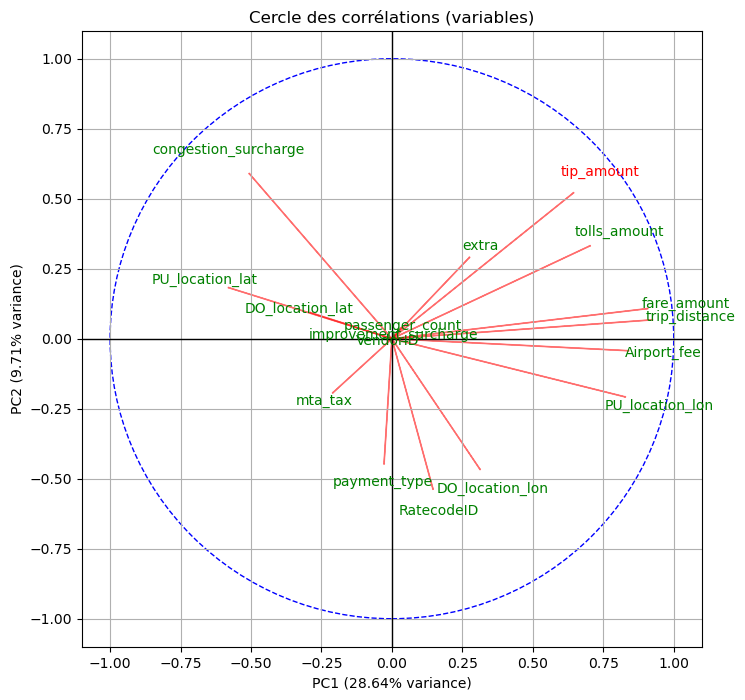

In [28]:
def plot_correlation_circle(loadings, labels, pca, axis):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    axe1, axe2 = axis

    # Définir un cercle de référence pour mieux visualiser
    circle = plt.Circle((0, 0), 1, color='b', fill=False, linestyle='--', linewidth=1)
    ax.add_artist(circle)

    # Tracer les flèches pour chaque variable
    for i in range(len(loadings)):
        plt.arrow(0, 0, loadings[i, axe1], loadings[i, axe2], color='r', alpha=0.5)
        if labels[i] == "tip_amount" :
            plt.text(loadings[i, axe1]*1.15, loadings[i, axe2]*1.15, labels[i], color='red', ha='center', va='center')
        else :
            plt.text(loadings[i, axe1]*1.15, loadings[i, axe2]*1.15, labels[i], color='g', ha='center', va='center')

    # Limites et étiquettes
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xlabel(f"PC{axe1+1} ({pca.explained_variance_ratio_[axe1]*100:.2f}% variance)")
    plt.ylabel(f"PC{axe2+1} ({pca.explained_variance_ratio_[axe2]*100:.2f}% variance)")
    plt.axhline(0, color='black',linewidth=1)
    plt.axvline(0, color='black',linewidth=1)
    plt.grid()
    plt.title('Cercle des corrélations (variables)')
    plt.show()

# Tracer le cercle des variables dans le plan (0,1)
plot_correlation_circle(loadings, labels=X_ACP.columns, pca=mypca, axis = (0,1))

Les variables les mieux représentées sont `fare_amount`, `trip_distance`, `Airport_fee`, `PU_location_lon` et `tip_amount`. On retrouve les fortes corrélations déjà observée entre `trip_distance` et `fare_amount`, et entre `PU_location_lon` et `Airport_fee`. Sur le premier plan, la variable `tip_amount` que l'on cherche à estimer est pricnipalement corrélée à `extra` et `tolls_amount`, et anti-corrélée à `mta_tax`. Malheureusement, les variables `extra` et `mta_tax` sont mal représentées sur le premier plan.

## étude variable par variable

In [29]:
train_df['store_and_fwd_flag'].value_counts()

N    99578
Y      422
Name: store_and_fwd_flag, dtype: int64

La variable `Store_and_fwd_flag` ne semble pas être la plus pertinente. Elle ne prend que 2 valeurs et 99.5% des individus sont `Non`. Il va être difficile d'en déterminer des patterns, mais nous décidons de l'encoder tout de même. 

In [32]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

le = LabelEncoder()
train_df['store_and_fwd_flag']=le.fit_transform(train_df['store_and_fwd_flag'])
train_df['store_and_fwd_flag'].value_counts()

0    99578
1      422
Name: store_and_fwd_flag, dtype: int64

In [37]:
train_df['RatecodeID'].value_counts()

1.0     95078
2.0      3439
99.0      968
3.0       262
5.0       235
4.0        18
Name: RatecodeID, dtype: int64

In [44]:
#Encoder 99 à 6 pour que nos modèles utilisant la distance donnent une mauvaise interpretabilité au modèle
train_df['RatecodeID'].replace(99., 6.)
train_df['RatecodeID'].value_counts()

1.0    95078
2.0     3439
6.0      968
3.0      262
5.0      235
4.0       18
Name: RatecodeID, dtype: int64

In [34]:
## création de nouvelles variables

Nous allons créer une colonne qui distingue l'heure et le jour. Nous encodons les jours et jour+heure

In [36]:
train_df['pickup_day'] = train_df['tpep_pickup_datetime'].dt.day
train_df['pickup_hour'] = train_df['tpep_pickup_datetime'].dt.hour + train_df['tpep_pickup_datetime'].dt.minute / 60


train_df['dropoff_day'] = train_df['tpep_dropoff_datetime'].dt.day
train_df['dropoff_hour'] = train_df['tpep_dropoff_datetime'].dt.hour + train_df['tpep_dropoff_datetime'].dt.minute / 60